In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import configparser
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import imgaug  # https://github.com/aleju/imgaug (pip3 install imgaug)
from imgaug import augmenters as iaa

# %matplotlib inline
config = configparser.ConfigParser()
config.read('config_default.ini')
ROOT_DIR = config.get('FILE_PATHS','root_dir_current')
Mask = config.get('SETTINGS','Mask')

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DATASET_PATH = config.get('FILE_PATHS', 'datasets_dir')
DEFAULT_LOGS_DIR = config.get('FILE_PATHS', 'logs_dir_current')
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [3]:
from MTL_MRCNN.config import Config
from MTL_MRCNN import utils
import MTL_MRCNN.model as modellib
from MTL_MRCNN import visualize
from MTL_MRCNN.model import log

class Shapeconfig(Config):
    
    NAME = "_ai-console_"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # Background and 1 class

    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    BACKBONE = "resnet50"

    MASK_SHAPE = [28, 28]
    LOSS_WEIGHTS= {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0,'rpn_pos_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 5.0, 'mrcnn_mask_loss': 1.0 ,'mrcnn_pos_loss': 1.0}
    LEARNING_RATE = 0.001
    POOL_SIZE = 7
    STEPS_PER_EPOCH = 1000
    
    # Skip detections with < 60% confidence
    DETECTION_MIN_CONFIDENCE = 0.6
    
    RPN_ANCHOR_SCALES= [64, 96, 128 ,256 ,320]
    RPN_ANCHOR_RATIOS=[0.7,0.8,0.9,1,1.1,1.2,1.3]
    
    MAX_GT_INSTANCES  = 5
    DETECTION_MAX_INSTANCES = 5
    POST_NMS_ROIS_INFERENCE = 5
    POST_NMS_ROIS_TRAINING = 1000
    TRAIN_ROIS_PER_IMAGE= 100
    ROI_POSITIVE_RATIO = 0.33
    RPN_TRAIN_ANCHORS_PER_IMAGE=500
    
    USE_RPN_ROIS = True;
    RPN_NMS_THRESHOLD = 0.7
    
    #////////  Set the maximum posible value of the attribute in the dataset  
    ##          (This value will be used for data normalization)/////////////////// 
    Attribute_max = 180.
    # If enabled, re-sizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = False
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

config=Shapeconfig()
config.display()


Configurations:
Attribute_max                  180.0
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        5
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_pos_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 5.0, 'mrcnn_mask_loss': 1.0, 'm

In [4]:
class LabelboxCocoDataset(utils.Dataset):
    def load_dataset(self, dataset_dir, dataset_name, class_ids=None):
        """Load a dataset_name of the COCO dataset_skeleton.
        dataset_dir: The root directory of the COCO dataset_skeleton.
        dataset_name: What to load (train, val)
        class_ids: If provided, only loads images that have the given classes.
        """

        coco = COCO("{}/{}.json".format(dataset_dir, dataset_name))
        image_dir = "{}".format(dataset_dir)
        

        # Load all classes or a dataset_name?
        if not class_ids:
            # All classes
            class_ids = sorted(coco.getCatIds())
        # All images or a dataset_name?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(coco.imgs.keys())
        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=coco.imgs[i]['file_name'],
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))        

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        Yawposition=[]
        Pitchposition=[]
        pos=[]
        
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))


           ## ////////////// rescale the attributes value if needed ////////////////////
            Pitch , Yaw = self.rescale(annotation['Yaw'], annotation['Pitch'])


            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)
                Yawposition.append(Yaw)
                Pitchposition.append(Pitch)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            Yawposition = np.array(Yawposition, dtype=np.float32)
            Pitchposition = np.array(Pitchposition, dtype=np.float32)
            pos = np.concatenate((Yawposition, Pitchposition) , axis = 0)
            

            return mask, class_ids , pos
        else:
            # Call super class to return an empty mask
            return super(CocoDataset, self).load_mask(image_id)
    
    def rescale (self, yaw, pitch):
        ###########    modify this function based on your attrinbutes if needed  ###############
        ##### Here beacuse of the range of yaw in BIWI dataset that varies form 0 to 180, we re-map it to 180 to 0.
        Pitch = pitch
        Yaw = yaw
        Yaw = abs(yaw -180)
        
        return Yaw, Pitch
            
    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
                
        m = maskUtils.decode(rle)
        
        return m
    
    
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

In [5]:
# Training dataset_skeleton. Use the training set and 35K from the
# validation set, as as in the Mask RCNN paper.


############################      Training dataset info     ##############################
dataset_train = LabelboxCocoDataset()
dataset_train.load_dataset(DATASET_PATH, "train")
dataset_train.prepare()

print("[INFO] Train dataset_skeleton info")
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

print(dataset_train.class_names)


############################     Validation dataset info    ###########################
dataset_val = LabelboxCocoDataset()
dataset_val.load_dataset(DATASET_PATH, "validation")
dataset_val.prepare()

print("[INFO] Train dataset_skeleton info")
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))


##########################        Test dataset info     #################################
dataset_test = LabelboxCocoDataset()
dataset_test.load_dataset(DATASET_PATH, "test")
dataset_test.prepare()

print("[INFO] test dataset_skeleton info")
print("Image Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
    print("{:3}. {:50}".format(i, info['name']))


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
[INFO] Train dataset_skeleton info
Image Count: 2401
Class Count: 2
  0. BG                                                
  1. Face                                              
['BG', 'Face']
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
[INFO] Train dataset_skeleton info
Image Count: 514
Class Count: 2
  0. BG                                                
  1. Face                                              
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
[INFO] test dataset_skeleton info
Image Count: 516
Class Count: 2
  0. BG                                                
  1. Face                                              


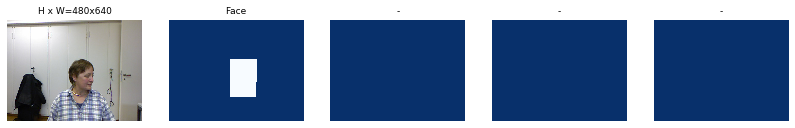

Image Path: ./images/Dataset/c0f037858827
Image attributes: [ 78. 139.]


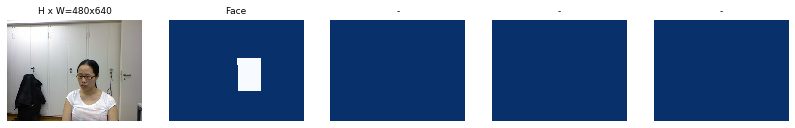

Image Path: ./images/Dataset/8e08dc84d5e6
Image attributes: [78. 66.]


In [6]:
# Load and display random samples
#######  Check the attribute values. If it is needed, modify LabelboxCocoDataset.Rescale to rescale the values. 
image_ids = np.random.choice(dataset_train.image_ids, 2)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids, pos = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    print("Image Path:", dataset_train.image_info[image_id]['path'])
    print("Image attributes:", pos)

In [8]:
print("Fine tune Resnet stage 4 and up")
config = Shapeconfig()
model = modellib.MTL_MRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR ,mask=Mask)

Fine tune Resnet stage 4 and up
AAAA shape is : (9548, 4)
[(None, 1000, 4), (None, None), (None, None, 4), (None, 128, 128, None), (None, None, 2)]


In [9]:
model_path = COCO_MODEL_PATH


model.load_weights(model_path, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_class",
                                "mrcnn_bbox_fc","roi_align_classifier2","mrcnn_pos1", "mrcnn_pos1_maxpooling",'mrcnn_class_bn122',
                                 "mrcnn_class_conv2111","mrcnn_pos1_maxpooling",'mrcnn_pos1_bn1',"mrcnn_pos1_conv3",
                                 'mrcnn_pos1_bn3', "mrcnn_pos1_pool_squeeze", "mrcnn_bbox","mrcnn_pos_logits","mrcnn_pos","rpn_model"])


# //////////////////////////////////////// Augmentaion filters  //////////////////////////////////////////
augmentation = [
                iaa.Sometimes(1 , [
                    iaa.Rain(speed=(0.1, 0.3)),
                ]),
                iaa.Sometimes(1 , [
                    iaa.pillike.EnhanceBrightness(),
                ]),
                iaa.Sometimes(1 , [
                    iaa.LogContrast(gain=(0.3, 0.9)),
                ]),
                iaa.Sometimes(1 , [
                    iaa.MotionBlur(k=5, angle=[-5, 5]),
                ])
               ]


print("Fine tune Resnet stage 4 and up")
'''Set the epoch number for training  '''

model.train(dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=20,     
    layers='heads',
    augmentation= augmentation)


model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)